In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/kunthshah/Desktop/Crypto-Price-Moevement-Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df = pd.read_csv('Dataset/crypto_price_movement_dataset_cleaned.csv') 
df.head()

,Date,Open_Price,High_Price,Low_Price,MA_5,MA_10,RSI,Price_Movement,MA_5_lag_2,MA_10_lag_2,MA_10_lag_7
0,2023-01-12,59097.295565,59900.004347,58784.035582,49045.482581,44580.256718,33.144940,False,44244.894607,45577.477694,0.0
1,2023-01-13,54973.279224,55396.713428,54378.735255,48852.372428,44929.860092,43.650581,True,43509.492070,44528.878721,0.0
2,2023-01-14,36370.173320,36938.992350,36371.219308,46570.552431,43760.010546,44.739048,True,49045.482581,44580.256718,0.0
3,2023-01-15,35454.749016,35211.603012,34107.853810,43367.089528,43805.992068,37.650721,False,48852.372428,44929.860092,0.0
4,2023-01-16,35502.135296,36428.171405,35625.323065,44297.612013,43903.552042,39.993981,True,46570.552431,43760.010546,0.0


In [4]:
df.dtypes

Date               object
Open_Price        float64
High_Price        float64
Low_Price         float64
MA_5              float64
MA_10             float64
RSI               float64
Price_Movement       bool
MA_5_lag_2        float64
MA_10_lag_2       float64
MA_10_lag_7       float64
dtype: object

In [5]:
# Exclude non-feature columns from scaling
cols_to_scale = df.columns.difference(['Date', 'Price_Movement'])

# Scale the features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[cols_to_scale])

# Create dataframe with scaled features
features_scaled_df = pd.DataFrame(scaled_values, columns=cols_to_scale, index=df.index)

# Add the target column back without scaling
features_scaled_df['Price_Movement'] = df['Price_Movement']
features_scaled_df['Date'] = df['Date']

print(features_scaled_df.head())

   High_Price  Low_Price     MA_10  MA_10_lag_2  MA_10_lag_7      MA_5  \
0    1.666637   1.653700 -0.141513     0.224575   -16.285208  1.053959   
1    1.146589   1.144921 -0.013172    -0.160369   -16.285208  1.004070   
2   -0.984941  -0.934809 -0.442628    -0.141508   -16.285208  0.414565   
3   -1.184423  -1.196210 -0.425748    -0.013168   -16.285208 -0.413045   
4   -1.043932  -1.020954 -0.389933    -0.442623   -16.285208 -0.172646   

   MA_5_lag_2  Open_Price       RSI  Price_Movement        Date  
0   -0.186237    1.633314 -1.464828           False  2023-01-12  
1   -0.376228    1.156652 -0.553939            True  2023-01-13  
2    1.053994   -0.993528 -0.459564            True  2023-01-14  
3    1.004104   -1.099335 -1.074156           False  2023-01-15  
4    0.414597   -1.093858 -0.870984            True  2023-01-16  


In [6]:
# Define the window size
window_size = 10

def create_time_windows(data, window_size):
    X_windows = []
    y_windows = []
    
    # Loop starting from window_size to the end of data rows
    for i in range(window_size, len(data)):
        # Get window of features for the previous window_size days
        X_window = data.iloc[i-window_size:i].values
        # Get the target for the current day (could be adjusted as needed)
        y_window = features_scaled_df.iloc[i]['Price_Movement']
        X_windows.append(X_window)
        y_windows.append(y_window)
    
    return np.array(X_windows), np.array(y_windows)

# Prepare features (drop Date and Price_Movement columns)
features = features_scaled_df.drop(['Date', 'Price_Movement'], axis=1)

# Create the windows
X_seq, y_seq = create_time_windows(features, window_size)

# Check the shapes. X_seq should have shape (samples, 30, num_features)
print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)

X_seq shape: (49979, 10, 9)
y_seq shape: (49979,)


In [7]:
def create_train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):

    n = len(X)
    
    # Calculate the split indices
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    # Split the data
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create the splits with default 70-15-15 ratio
X_train, y_train, X_val, y_val, X_test, y_test = create_train_val_test_split(X_seq, y_seq)

# Print the shapes to verify
print(f"Training set: X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Validation set: X shape = {X_val.shape}, y shape = {y_val.shape}")
print(f"Test set: X shape = {X_test.shape}, y shape = {y_test.shape}")

Training set: X shape = (34985, 10, 9), y shape = (34985,)
Validation set: X shape = (7496, 10, 9), y shape = (7496,)
Test set: X shape = (7498, 10, 9), y shape = (7498,)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Combine train and validation data for cross-validation
# Assuming X_train, y_train, X_val, y_val are already defined
X_combined = np.concatenate([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Get shapes for model creation
_, timesteps, n_features = X_combined.shape

# Define the model creation function (unchanged)
def create_lstm_model(timesteps, n_features):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Set up K-fold cross-validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists to store metrics
fold_train_losses = []
fold_val_losses = []
fold_train_accs = []
fold_val_accs = []
all_conf_matrices = []
histories = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_combined)):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data for this fold
    X_train_fold, X_val_fold = X_combined[train_idx], X_combined[val_idx]
    y_train_fold, y_val_fold = y_combined[train_idx], y_combined[val_idx]
    
    # Create a fresh model for each fold
    model = create_lstm_model(timesteps, n_features)
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(f'best_lstm_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    
    # Store training history
    histories.append(history)
    
    # Evaluate on training and validation data
    train_loss, train_acc = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    
    # Store metrics
    fold_train_losses.append(train_loss)
    fold_val_losses.append(val_loss)
    fold_train_accs.append(train_acc)
    fold_val_accs.append(val_acc)
    
    # Calculate predictions and confusion matrix
    y_pred = (model.predict(X_val_fold) > 0.5).astype(int).flatten()
    all_conf_matrices.append(confusion_matrix(y_val_fold, y_pred))
    
    print(f"Fold {fold+1} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    print(classification_report(y_val_fold, y_pred))


Fold 1/5
Epoch 1/10
529/531 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5018 - loss: 0.7280

531/531 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5018 - loss: 0.7279 - val_accuracy: 0.4948 - val_loss: 0.6953
Epoch 2/10
524/531 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5051 - loss: 0.6970

531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5051 - loss: 0.6970 - val_accuracy: 0.4984 - val_loss: 0.6938
Epoch 3/10
528/531 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4985 - loss: 0.6954

531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4985 - loss: 0.6954 - val_accuracy: 0.4970 - val_loss: 0.6938
Epoch 4/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5014 - loss: 0.6946 - val_accuracy: 0.4942 - val_loss: 0.6940
Epoch 5/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5056 - loss: 0.6939 - val_accuracy: 0.4971 - val_loss: 0.6942
Epoch 6/10
522/531 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5051 - loss: 0.6935

531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5051 - loss: 0.6935 - val_accuracy: 0.5055 - val_loss: 0.6934
Epoch 7/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5043 - loss: 0.6937

531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5043 - loss: 0.6937 - val_accuracy: 0.5085 - val_loss: 0.6934
Epoch 8/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5046 - loss: 0.6937 - val_accuracy: 0.4966 - val_loss: 0.6940
Epoch 9/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5058 - loss: 0.6937 - val_accuracy: 0.4962 - val_loss: 0.6943
Epoch 10/10
531/531 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5085 - loss: 0.6938 - val_accuracy: 0.4979 - val_loss: 0.6939
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 - Train Acc: 0.5114, Val Acc: 0.5085
              precision    recall  f1-score   support

       False       0.50      0.21      0.29      4178
        True       0.51      0.80      0.62      4319

    accuracy                           0.51      8497
   macro avg       0.51      0.50      0.46      8497
weighted avg       0.51      0.51      0.46      8497


Fold 2/5
Epoch 1/10
524/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4926 - los

532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4927 - loss: 0.7299 - val_accuracy: 0.4989 - val_loss: 0.6942
Epoch 2/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5026 - loss: 0.6972 - val_accuracy: 0.5004 - val_loss: 0.6948
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5056 - loss: 0.6948 - val_accuracy: 0.4984 - val_loss: 0.6947
Epoch 4/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4964 - loss: 0.6950

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4964 - loss: 0.6950 - val_accuracy: 0.5041 - val_loss: 0.6934
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5040 - loss: 0.6944 - val_accuracy: 0.4891 - val_loss: 0.6952
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5009 - loss: 0.6940 - val_accuracy: 0.4893 - val_loss: 0.6939
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5010 - loss: 0.6937 - val_accuracy: 0.5075 - val_loss: 0.6935
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4998 - loss: 0.6939 - val_accuracy: 0.4992 - val_loss: 0.6941
Epoch 9/10
526/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5077 - loss: 0.6939

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5077 - loss: 0.6939 - val_accuracy: 0.5052 - val_loss: 0.6933
Epoch 10/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5122 - loss: 0.6932 - val_accuracy: 0.5021 - val_loss: 0.6940
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 2 - Train Acc: 0.5027, Val Acc: 0.5052
              precision    recall  f1-score   support

       False       0.49      0.28      0.36      4180
        True       0.51      0.72      0.60      4316

    accuracy                           0.51      8496
   macro avg       0.50      0.50      0.48      8496
weighted avg       0.50      0.51      0.48      8496


Fold 3/5
Epoch 1/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4965 - loss: 0.7594

532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4965 - loss: 0.7593 - val_accuracy: 0.5028 - val_loss: 0.6965
Epoch 2/10
523/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4976 - loss: 0.7028

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4977 - loss: 0.7028 - val_accuracy: 0.4959 - val_loss: 0.6963
Epoch 3/10
525/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5061 - loss: 0.6965

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5060 - loss: 0.6965 - val_accuracy: 0.5074 - val_loss: 0.6932
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5042 - loss: 0.6960 - val_accuracy: 0.5046 - val_loss: 0.6934
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5025 - loss: 0.6953 - val_accuracy: 0.5040 - val_loss: 0.6938
Epoch 6/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5089 - loss: 0.6942

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5089 - loss: 0.6942 - val_accuracy: 0.5106 - val_loss: 0.6931
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5008 - loss: 0.6948 - val_accuracy: 0.5032 - val_loss: 0.6933
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5036 - loss: 0.6941 - val_accuracy: 0.5068 - val_loss: 0.6933
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4998 - loss: 0.6943 - val_accuracy: 0.5032 - val_loss: 0.6938
Epoch 10/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5023 - loss: 0.6942 - val_accuracy: 0.5029 - val_loss: 0.6936
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 3 - Train Acc: 0.5071, Val Acc: 0.5106
              precision    recall  f1-score   support

       False       0.51      0.60      0.55      4258
        True       0.51      0.42      0.46      4238

    accuracy                           0.51      8496
   macro avg       0.51      0.51      0.51      8496
weighted avg 

532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5030 - loss: 0.7324 - val_accuracy: 0.5085 - val_loss: 0.6950
Epoch 2/10
523/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4999 - loss: 0.6989

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4999 - loss: 0.6989 - val_accuracy: 0.5042 - val_loss: 0.6949
Epoch 3/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4997 - loss: 0.6969 - val_accuracy: 0.5016 - val_loss: 0.6950
Epoch 4/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5086 - loss: 0.6942

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5086 - loss: 0.6942 - val_accuracy: 0.5022 - val_loss: 0.6938
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5025 - loss: 0.6940 - val_accuracy: 0.4959 - val_loss: 0.6963
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5029 - loss: 0.6944 - val_accuracy: 0.5001 - val_loss: 0.6944
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5070 - loss: 0.6939 - val_accuracy: 0.5009 - val_loss: 0.6939
Epoch 8/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5074 - loss: 0.6934

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5074 - loss: 0.6934 - val_accuracy: 0.5032 - val_loss: 0.6938
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5074 - loss: 0.6936 - val_accuracy: 0.5039 - val_loss: 0.6940
Epoch 10/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5104 - loss: 0.6937 - val_accuracy: 0.4962 - val_loss: 0.6941
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 4 - Train Acc: 0.5216, Val Acc: 0.5032
              precision    recall  f1-score   support

       False       0.50      0.45      0.47      4186
        True       0.51      0.56      0.53      4310

    accuracy                           0.50      8496
   macro avg       0.50      0.50      0.50      8496
weighted avg       0.50      0.50      0.50      8496


Fold 5/5
Epoch 1/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5008 - loss: 0.7198

532/532 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5008 - loss: 0.7198 - val_accuracy: 0.4946 - val_loss: 0.6972
Epoch 2/10
527/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4953 - loss: 0.6988

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4954 - loss: 0.6988 - val_accuracy: 0.4921 - val_loss: 0.6967
Epoch 3/10
531/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5134 - loss: 0.6946

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5134 - loss: 0.6946 - val_accuracy: 0.5072 - val_loss: 0.6936
Epoch 4/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5013 - loss: 0.6957 - val_accuracy: 0.5006 - val_loss: 0.6943
Epoch 5/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5065 - loss: 0.6950

532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5065 - loss: 0.6950 - val_accuracy: 0.5038 - val_loss: 0.6934
Epoch 6/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5018 - loss: 0.6942 - val_accuracy: 0.4942 - val_loss: 0.6953
Epoch 7/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5064 - loss: 0.6940 - val_accuracy: 0.5038 - val_loss: 0.6960
Epoch 8/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5024 - loss: 0.6945 - val_accuracy: 0.4953 - val_loss: 0.6949
Epoch 9/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4984 - loss: 0.6943 - val_accuracy: 0.4889 - val_loss: 0.6949
Epoch 10/10
532/532 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4964 - loss: 0.6945 - val_accuracy: 0.5012 - val_loss: 0.6934
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 5 - Train Acc: 0.5094, Val Acc: 0.5038
              precision    recall  f1-score   support

       False       0.52      0.32      0.39      4297
        True       0.50      0.69      0.58     


==== Cross-Validation Results ====
Average Training Accuracy: 0.5104 ± 0.0063
Average Validation Accuracy: 0.5062 ± 0.0029
Average Training Loss: 0.6929 ± 0.0005
Average Validation Loss: 0.6934 ± 0.0002


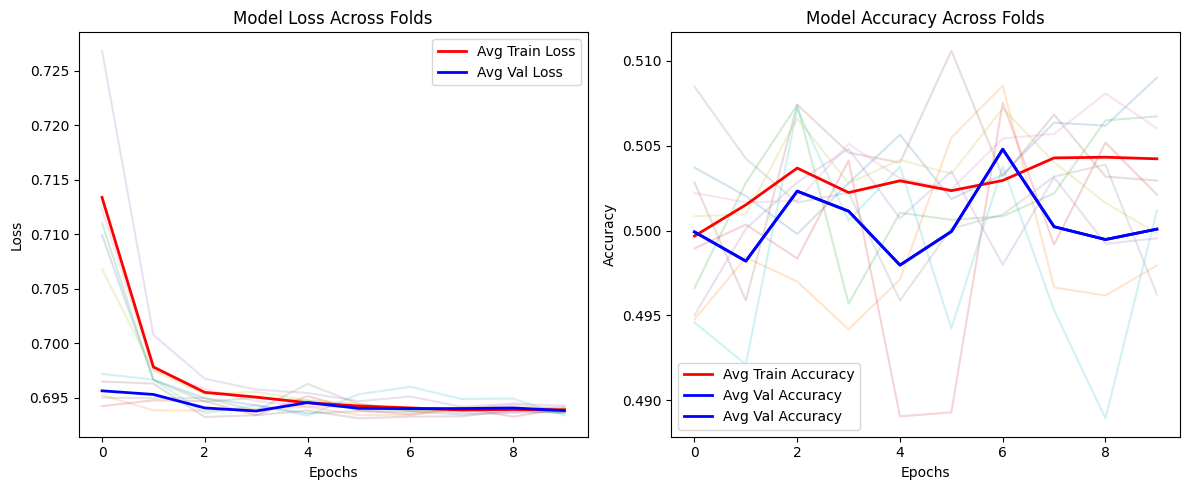

In [9]:
# Print average results
print("\n==== Cross-Validation Results ====")
print(f"Average Training Accuracy: {np.mean(fold_train_accs):.4f} ± {np.std(fold_train_accs):.4f}")
print(f"Average Validation Accuracy: {np.mean(fold_val_accs):.4f} ± {np.std(fold_val_accs):.4f}")
print(f"Average Training Loss: {np.mean(fold_train_losses):.4f} ± {np.std(fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(fold_val_losses):.4f} ± {np.std(fold_val_losses):.4f}")

# Plot average learning curves
plt.figure(figsize=(12, 5))

# Plot average loss
plt.subplot(1, 2, 1)
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], alpha=0.2)
    plt.plot(history.history['val_loss'], alpha=0.2)

min_epochs = min(len(history.history['loss']) for history in histories)
avg_train_loss = np.mean([history.history['loss'][:min_epochs] for history in histories], axis=0)
avg_val_loss = np.mean([history.history['val_loss'][:min_epochs] for history in histories], axis=0)
plt.plot(avg_train_loss, 'r-', linewidth=2, label='Avg Train Loss')
plt.plot(avg_val_loss, 'b-', linewidth=2, label='Avg Val Loss')
plt.title('Model Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot average accuracy
plt.subplot(1, 2, 2)
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], alpha=0.2)
    plt.plot(history.history['val_accuracy'], alpha=0.2)

min_epochs_acc = min(len(history.history['accuracy']) for history in histories)
avg_train_acc = np.mean([history.history['accuracy'][:min_epochs_acc] for history in histories], axis=0)
avg_val_acc = np.mean([history.history['val_accuracy'][:min_epochs_acc] for history in histories], axis=0)
plt.plot(avg_train_acc, 'r-', linewidth=2, label='Avg Train Accuracy')
plt.plot(avg_val_acc, 'b-', linewidth=2, label='Avg Val Accuracy')
plt.plot(avg_val_acc, 'b-', linewidth=2, label='Avg Val Accuracy')
plt.title('Model Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Merge the training and validation sets
X_final = np.concatenate([X_train, X_val], axis=0)
y_final = np.concatenate([y_train, y_val], axis=0)

# Create and train the final model
final_model = create_lstm_model(timesteps, n_features)
callbacks_final = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history_final = final_model.fit(
    X_final,
    y_final,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks_final,
    verbose=1
)

# Evaluate the model on the test set and make predictions
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
y_test_pred = (final_model.predict(X_test) > 0.5).astype(int).flatten()

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Epoch 1/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4973 - loss: 0.7279 - val_accuracy: 0.4980 - val_loss: 0.6961
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5048 - loss: 0.6976 - val_accuracy: 0.5041 - val_loss: 0.6935
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4970 - loss: 0.6960 - val_accuracy: 0.5086 - val_loss: 0.6937
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5018 - loss: 0.6949 - val_accuracy: 0.4860 - val_loss: 0.6948
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4987 - loss: 0.6949 - val_accuracy: 0.5102 - val_loss: 0.6934
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5045 - loss: 0.6941 - val_accuracy: 0.4980 - val_loss: 0.6941
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5057 - loss: 0.6938 - val_accuracy: 0.5126 - val_loss: 0.6930
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5036 - loss: 0.6941 - val_accuracy: 0.